# Installing dependencies

In [ ]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import pandas as pd
import plotly.express as px

In [ ]:
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

In [ ]:
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device

device = set_device()

GPU is enabled in this notebook.


# Data preparation

In [ ]:
spectrograms_dir = "Data/images_original/"
folder_names = ['Data/train/', 'Data/test/', 'Data/val/', 'Data/all/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]
all_dir = folder_names[3]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.png"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)
  test_files = src_file_paths[0:10]
  val_files = src_file_paths[10:20]
  train_files = src_file_paths[20:]
  all_files = src_file_paths[:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in all_files:
    shutil.copy(f, os.path.join(os.path.join(all_dir + f"{g}") + '/',os.path.split(f)[1]))

In [ ]:
train_dataset = datasets.ImageFolder(
    train_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, shuffle=True, num_workers=0)

val_dataset = datasets.ImageFolder(
    val_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=32, shuffle=True, num_workers=0)

test_dataset = datasets.ImageFolder(
    test_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=10, shuffle=True, num_workers=0)

all_dataset = datasets.ImageFolder(
    all_dir,
    transforms.Compose([
        transforms.ToTensor(),
    ]))

lll_loader = torch.utils.data.DataLoader(
    all_dataset, batch_size=20, shuffle=True, num_workers=0)

# AutoEnconder (basic)

In [ ]:
class AE(nn.Module):
  def __init__(self):
    super(AE, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0)


    self.bn16 = nn.BatchNorm2d(16)
    self.bn8 = nn.BatchNorm2d(8)
    self.flatten = nn.Flatten(start_dim=1)
    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 35, 53))

    self.fc1 = nn.Linear(59360, 128)
    self.fc2 = nn.Linear(128, 3)
    self.fc5 = nn.Linear(3, 128)
    self.fc6 = nn.Linear(128, 59360)

    self.t_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, output_padding=1)
    self.t_conv2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.t_conv3 = nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1)



  def encode(self, x):
    #Conv
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    #Linear
    x = self.flatten(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  def decode(self, x):
    #Linear
    x = F.relu(self.fc5(x))
    x = F.relu(self.fc6(x))
    x = self.unflatten(x)
    #Conv
    x = F.relu(self.t_conv1(x))
    x = F.relu(self.t_conv2(x))
    x = self.t_conv3(x)
    return x

  def forward(self, x):
    coded = self.encode(x)
    reconstructed = self.decode(coded)
    reconstructed = torch.sigmoid(reconstructed)
    return reconstructed

ae = AE().to(device)

# AutoEnconder (for TSNE)

In [ ]:
from torch.nn.modules.activation import ReLU
from torch.nn.modules.linear import Linear
class ConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 16, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(16, 32, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.MaxPool2d(2),
        )

        self.decoder = torch.nn.Sequential(
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(128, 64, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(64, 32, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(32, 16, 3, padding='same'),
            torch.nn.ReLU(True),
            torch.nn.Dropout(0.2),
            torch.nn.Upsample(scale_factor=2),
            torch.nn.Conv2d(16, 3, 3, padding='same'),
        )

        self.linear_down = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=1),
            torch.nn.Linear(62208, 500),
            torch.nn.ReLU(),
         )

        self.linear_up = torch.nn.Sequential(
            torch.nn.Linear(500, 62208),
            torch.nn.Unflatten(dim=1, unflattened_size=(128, 18, 27)),
         )

    def encode(self, x):
        enc = self.encoder(x)
        #return enc
        return self.linear_down(enc)

    def forward(self, x):
        coded = self.encoder(x)
        coded = self.linear_up(self.linear_down(coded))
        return self.decoder(coded)


cnv = ConvAutoencoder().to(device)

# Training function (basic)

In [ ]:
### Training function
def train_ae(model, device, train, val, epoch, L1 = False, L2 = False):
  train_loss = []
  val_loss = []
  loss_fn = torch.nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-05)

  with tqdm(range(epoch), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      running_loss = []


      for image_batch, _ in train:
        image_batch = image_batch.to(device)
        optimizer.zero_grad()
        decoded = model(image_batch)
        loss = loss_fn(decoded, image_batch)

        if L2:
          #L2 regularization
          l2_lambda = 0.001
          l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
          loss = loss + l2_lambda * l2_norm

        if L1:
          #L1 regularization
          l1_lambda = 0.001
          l1_norm = sum(p.abs().sum() for p in model.parameters())
          loss = loss + l1_lambda * l1_norm

        loss.backward()
        optimizer.step()
        tepochs.set_postfix(loss=loss.item())
        running_loss.append(loss.item())

      train_loss.append(np.mean(running_loss))

      model.eval()

      running_loss = []
      for image_batch, _ in train:
          image_batch = image_batch.to(device)
          optimizer.zero_grad()
          decoded = model(image_batch)
          #print(image_batch.shape)
          #print(decoded.shape)
          loss = loss_fn(decoded, image_batch)
          # Backward pass
          loss.backward()
          optimizer.step()
          # Print batch loss
          tepochs.set_postfix(loss=loss.item())
          running_loss.append(loss.item())

      val_loss.append(np.mean(running_loss))

  return train_loss, val_loss

# Results

In [ ]:
tr, val = train_ae(ae, device, train_loader, val_loader, 20)

  0%|          | 0/20 [00:00<?, ?epoch/s]

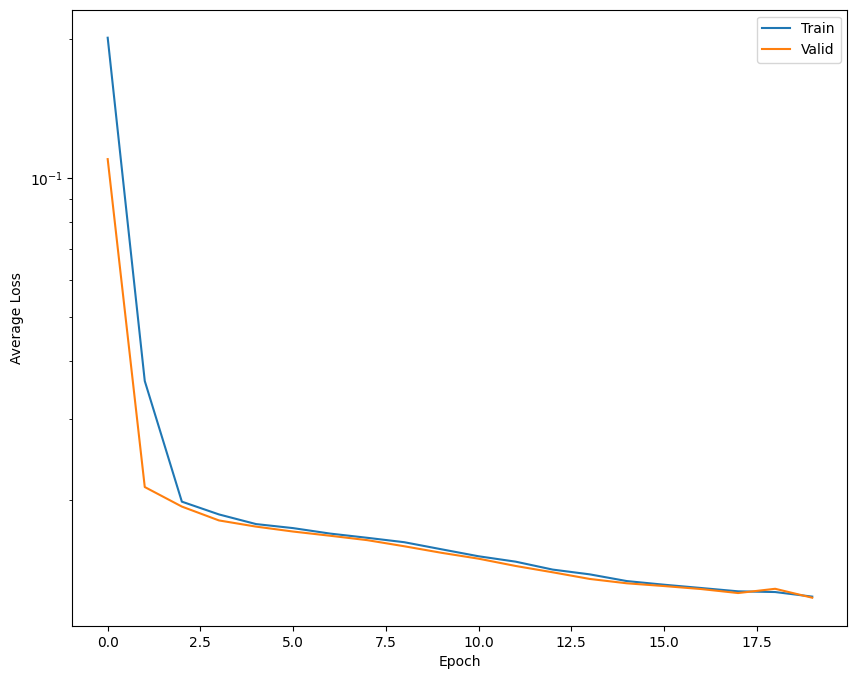

In [ ]:
# Plot losses
plt.figure(figsize=(10,8))
plt.semilogy(tr, label='Train')
plt.semilogy(val, label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

# Plots

In [ ]:
def encode_samp(model=None, rand= False, dataset = all_dataset):
  encoded_samples = []
  if rand:
    model = AE().to(device)
  for sample in tqdm(dataset):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      model.eval()
      with torch.no_grad():
          encoded_img  = model.encode(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  encoded_samples = pd.DataFrame(encoded_samples)
  return encoded_samples

In [ ]:
encoded_samples = encode_samp(ae, dataset = all_dataset)


  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
test = encode_samp(ae, dataset = test_dataset)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
encoded_samples_rand = encode_samp(rand=True)

  0%|          | 0/999 [00:00<?, ?it/s]

In [ ]:
# Model plot
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
#Random plot

px.scatter(encoded_samples_rand, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
# Model 3d plot
px.scatter_3d(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', z = 'Enc. Variable 2',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
#Random 3d plot
px.scatter_3d(encoded_samples_rand, x='Enc. Variable 0', y='Enc. Variable 1', z = 'Enc. Variable 2',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
px.scatter_3d(test, x='Enc. Variable 0', y='Enc. Variable 1', z = 'Enc. Variable 2',
           color=test.label.astype(str), opacity=0.7)

# Other

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
test_samples =  encode_samp(cnv, dataset = train_dataset)

  0%|          | 0/799 [00:00<?, ?it/s]

In [ ]:
trainx = encoded_samples.drop(['label'],axis=1)
trainy = encoded_samples['label']

In [ ]:
testx = test_samples.drop(['label'],axis=1)
testy = test_samples['label']

In [ ]:
test_samples


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 62199,Enc. Variable 62200,Enc. Variable 62201,Enc. Variable 62202,Enc. Variable 62203,Enc. Variable 62204,Enc. Variable 62205,Enc. Variable 62206,Enc. Variable 62207,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
795,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
796,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9
797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


In [ ]:
scaler = StandardScaler().fit(trainx)
trainx = scaler.transform(trainx)

In [ ]:
testx = scaler.transform(testx)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



In [ ]:
!pip install umap_learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap_learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=6eef7d092518772e928815bcadaa0b525ff9342fd6e0ff576d968fd484e96b30
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=0f17196cb883a4e4895c791866bde825b00d1f8830b9ea7f26b002eba7462c75
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap_learn pynndescent


In [ ]:
from umap import UMAP

In [ ]:
embedding = UMAP(n_neighbors=15, min_dist = 0.0).fit_transform(encoded_samples.drop('label', axis=1))
fig = px.scatter(embedding, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [ ]:
umap = UMAP().fit(trainx, trainy)

In [ ]:
embedding = umap.transform(testx)
fig = px.scatter(embedding, x=0, y=1,
                 color=test_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()


In [ ]:
embedding = umap.transform(trainx)
fig = px.scatter(embedding, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()